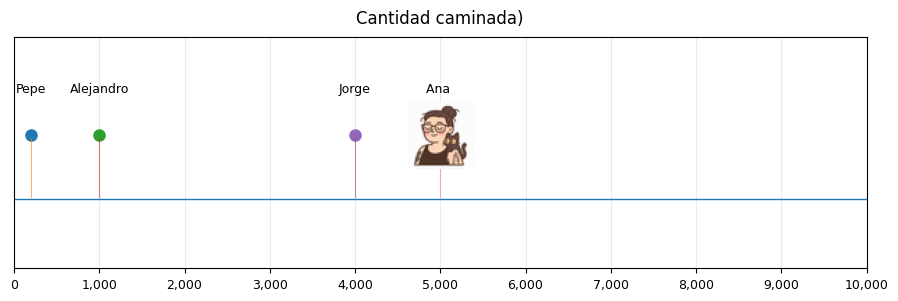

In [13]:
# @title
import os, io, requests
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# --- Your published CSV link ---
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vT2_0hqikR5l91BeYz_3ndukNZjRWq1cC5Cbh2RhkrEdqSaAlhYrxsE9bADLnIzVLyuEkWzQfllh12H/pub?gid=0&single=true&output=csv"

# --- Load & clean ---
df = pd.read_csv(url)
df = df.dropna(how="all")

# Standardize columns: A=name, B=Pasos, C=icono
cols = list(df.columns)
rename = {cols[0]: "Nombre", cols[1]: "Pasos"}
if len(cols) >= 3:
    rename[cols[2]] = "Icon"
df = df.rename(columns=rename)

# Drop rows without a name and coerce Pasos to int
df = df.dropna(subset=["Nombre"])
df["Pasos"] = (
    df["Pasos"].astype(str).str.replace(",", "", regex=False)
    .pipe(pd.to_numeric, errors="coerce")
)
df = df.dropna(subset=["Pasos"])
df["Pasos"] = df["Pasos"].astype(int)

# --- Helpers for icons ---
def is_url(s: str) -> bool:
    return isinstance(s, str) and s.lower().startswith(("http://", "https://"))

def looks_img_path(s: str) -> bool:
    if not isinstance(s, str): return False
    s = s.lower()
    return s.endswith((".png", ".jpg", ".jpeg", ".webp"))

def fetch_image(icon_str: str, px: int = 48):
    """Return a PIL image (px x px) from URL or local path; None on failure."""
    try:
        if is_url(icon_str):
            r = requests.get(icon_str, timeout=10)
            r.raise_for_status()
            img = Image.open(io.BytesIO(r.content)).convert("RGBA")
        else:
            if not os.path.exists(icon_str): return None
            img = Image.open(icon_str).convert("RGBA")
        return img.resize((px, px), Image.LANCZOS)
    except Exception as e:
        print(f"[warn] Could not load image '{icon_str}': {e}")
        return None

def draw_png(ax, x, y, pil_img):
    oi = OffsetImage(pil_img, zoom=1.0)
    ab = AnnotationBbox(oi, (x, y), frameon=False, box_alignment=(0.5, 0.5))
    ax.add_artist(ab)

# --- Axis scale: 2× the current max ---
max_value = int(df["Pasos"].max()) if not df.empty else 0
MAX_STEPS = max(max_value * 2, 10)  # ensure at least some range

# --- Plot ---
fig, ax = plt.subplots(figsize=(11, 3))
ax.axhline(0, linewidth=1)

# Stack icons if several share the same x
STACK_STEP = 0.35
groups = {}
for _, row in df.iterrows():
    x = int(row["Pasos"])
    groups.setdefault(x, []).append(row)

for x, rows in sorted(groups.items()):
    n = len(rows)
    start_y = 0.55 - (n - 1) * (STACK_STEP / 2.0)
    for i, row in enumerate(rows):
        y = start_y + i * STACK_STEP
        name = str(row["Nombre"])
        steps = int(row["Pasos"])
        icon = str(row.get("Icon", "")).strip() if "Icon" in row and pd.notna(row.get("Icon")) else ""

        placed = False
        if icon:
            if is_url(icon) or looks_img_path(icon):
                img = fetch_image(icon, px=48)
                if img is not None:
                    draw_png(ax, steps, y, img)
                    placed = True
            else:
                # emoji or short text
                ax.text(steps, y, icon, ha="center", va="center", fontsize=22)
                placed = True

        if not placed:
            ax.plot(steps, y, "o", markersize=8)

        # Show ONLY the name above the icon/marker
        ax.text(steps, y + 0.35, name, ha="center", va="bottom", fontsize=9)

        # Connector to baseline
        ax.plot([steps, steps], [0.02, y - 0.02], linewidth=0.8, alpha=0.6)

# x-axis ticks ~10 divisions
tick_step = max(1, MAX_STEPS // 10)
ticks = list(range(0, MAX_STEPS + 1, tick_step))
ax.set_xlim(0, MAX_STEPS)
ax.set_xticks(ticks)
ax.set_xticklabels([f"{t:,}" for t in ticks], fontsize=9)

ax.set_ylim(-0.6, 1.4)
ax.set_yticks([])
ax.grid(axis="x", alpha=0.25)
ax.set_title(f"Cantidad caminada)", fontsize=12, pad=10)

plt.show()

